Download colab_utils and import



<a href="https://colab.research.google.com/github/beangoben/rdkit_colab/blob/master/Template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


In [2]:
!wget https://raw.githubusercontent.com/beangoben/workshop_template/master/colab_utils.py -O colab_utils.py
!rm -rf sample_data
import colab_utils

--2020-08-25 03:33:51--  https://raw.githubusercontent.com/beangoben/workshop_template/master/colab_utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7173 (7.0K) [text/plain]
Saving to: ‘colab_utils.py’

colab_utils.py      100%[===================>]   7.00K  --.-KB/s    in 0s      

2020-08-25 03:33:51 (76.8 MB/s) - ‘colab_utils.py’ saved [7173/7173]



Clone github repo, install stuff

In [3]:
github_repo = 'https://github.com/beangoben/gnn_workshop_riiaa'
colab_utils.clone_repo(github_repo)
colab_utils.pip_install_from_yaml()

CMD: git clone --recursive https://github.com/beangoben/gnn_workshop_riiaa
pip installing ['tensorflow-probability', 'dm-sonnet', 'graph_nets', 'umap-learn', 'ogb']
CMD: pip install  tensorflow-probability
CMD: pip install  dm-sonnet
CMD: pip install  graph_nets
Created wheel for graph-nets: filename=graph_nets-1.1.0-cp36-none-any.whl size=91865 sha256=04452addd88c5988dd0e6503b0d501dee4de026f0b32b68e58979b93b4fa1f03
Stored in directory: /root/.cache/pip/wheels/c9/85/dc/ad3c616f83f0774ff12d6d7599850f56d82976e8590e59e864
Successfully built graph-nets
CMD: pip install  umap-learn
CMD: pip install  ogb
Created wheel for outdated: filename=outdated-0.2.0-cp36-none-any.whl size=4961 sha256=9cd2a0d52effefeffb570a5222a1ca44466c3d834fa554b7e142d36a7cb04bec
Stored in directory: /root/.cache/pip/wheels/fd/7c/ef/814f514d31197310872b5abf353feb8fef9d67ee658e1e7e39
Created wheel for littleutils: filename=littleutils-0.2.2-cp36-none-any.whl size=7051 sha256=2c00fc750daf52a0ec2377c63e91e17394374204070a

In [38]:
# Lint as: python3
"""Extra functions for manipulating GraphsTuple objects."""
from typing import Iterator

import graph_nets
import numpy as np
import tensorflow.compat.v2 as tf
import tree


GraphsTuple = graph_nets.graphs.GraphsTuple

# Alias to mirror the tf version.
cast_to_np = graph_nets.utils_tf.nest_to_numpy

# Numpy and tf compatible version of graph_nets.utils_tf.get_num_graphs
get_num_graphs = lambda graph: graph.n_node.shape[0]


def get_input_spec(x: GraphsTuple) -> tf.TensorSpec:
  """Gets input signature for a graphstuple, useful for tf.function."""
  return graph_nets.utils_tf.specs_from_graphs_tuple(x, dynamic_num_graphs=True)


def print_graphs_tuple(graphs: GraphsTuple):
  """Print a graph tuple's shapes and contents."""
  print("Shapes of GraphsTuple's fields:")
  print(
      graphs.map(
          lambda x: x if x is None else x.shape,
          fields=graph_nets.graphs.ALL_FIELDS))


def cast_to_tf(graphs: GraphsTuple) -> GraphsTuple:
  """Convert GraphsTuple numpy arrays to tf.Tensor."""

  def cast_fn(x):
    return tf.convert_to_tensor(x) if isinstance(x, np.ndarray) else x

  return tree.map_structure(cast_fn, graphs)


def split_graphs_tuple(graphs: GraphsTuple) -> Iterator[GraphsTuple]:
  """Converts several grouped graphs into a list of single graphs."""
  n = get_num_graphs(graphs)
  nodes = []
  node_offsets = [0] + np.cumsum(graphs.n_node).tolist()
  for i, j in zip(node_offsets[:-1], node_offsets[1:]):
    nodes.append(graphs.nodes[i:j])
  edges = []
  has_edges = graphs.edges is not None
  receivers, senders = [], []
  edge_offsets = [0] + np.cumsum(graphs.n_edge).tolist()
  for node_offset, i, j in zip(node_offsets[:-1], edge_offsets[:-1],
                               edge_offsets[1:]):
    if has_edges:
      edges.append(graphs.edges[i:j])
    else:
      edges.append(None)

    receivers.append(graphs.receivers[i:j] - node_offset)
    senders.append(graphs.senders[i:j] - node_offset)

  if graphs.globals is None:
    g_globals = [None for i in range(n)]
  else:
    g_globals = [graphs.globals[i] for i in range(n)]

  graph_list = map(GraphsTuple, nodes, edges, receivers, senders, g_globals,
                   graphs.n_node[:, np.newaxis], graphs.n_edge[:, np.newaxis])

  return graph_list


def get_graphs_tf(graphs: GraphsTuple, indices: np.ndarray) -> GraphsTuple:
  """Gets a new graphstuple (tf) based on a list of indices."""
  node_indices = tf.concat([tf.constant([0]), tf.cumsum(graphs.n_node)], axis=0)
  node_starts = tf.gather(node_indices, indices)
  node_ends = tf.gather(node_indices, indices + 1)
  node_slice = tf.ragged.range(node_starts, node_ends).values
  nodes = tf.gather(graphs.nodes, node_slice)

  edge_indices = tf.concat([tf.constant([0]), tf.cumsum(graphs.n_edge)], axis=0)
  edge_starts = tf.gather(edge_indices, indices)
  edge_ends = tf.gather(edge_indices, indices + 1)
  edge_slice = tf.ragged.range(edge_starts, edge_ends).values

  edges = tf.gather(graphs.edges,
                    edge_slice) if graphs.edges is not None else None

  n_edge = tf.gather(graphs.n_edge, indices)
  n_node = tf.gather(graphs.n_node, indices)

  offsets = tf.repeat(node_starts, tf.gather(graphs.n_edge, indices))
  senders = tf.gather(graphs.senders, edge_slice) - offsets
  receivers = tf.gather(graphs.receivers, edge_slice) - offsets
  new_offsets = tf.concat([tf.constant([0]), tf.cumsum(n_node)], axis=0)
  senders = senders + tf.repeat(new_offsets[:-1], n_edge)
  receivers = receivers + tf.repeat(new_offsets[:-1], n_edge)

  g_globals = tf.gather(graphs.globals,
                        indices) if graphs.globals is not None else None

  return GraphsTuple(
      nodes=nodes,
      edges=edges,
      globals=g_globals,
      senders=senders,
      receivers=receivers,
      n_node=n_node,
      n_edge=n_edge)


In [39]:
def save_graphtuples(filename: Text, graph: types.GraphsTuple):
  """Save a list of graphstuples with np.save."""
  np_graphs = graph_utils.split_graphs_tuple(graph_utils.cast_to_np(graph))
  data_dicts = list(
      map(graph_nets.utils_np.graphs_tuple_to_data_dicts, np_graphs))
  data_utils.cns_saver(filename, lambda f: np.save(f, data_dicts))


def load_graphstuples(filename: Text) -> types.GraphsTuple:
  """Load a list of graphstuples with np.load."""
  data = data_utils.cns_loader(filename,
                               lambda f: np.load(f, allow_pickle=True))
  return list(map(graph_nets.utils_tf.data_dicts_to_graphs_tuple, data))

NameError: ignored

# Import modules


In [5]:
from collections import OrderedDict
import tqdm.auto as tqdm

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import tensorflow as tf
import sonnet as snt
import graph_nets
import ogb

colab_utils.print_module_versions([tf, snt, ogb])
print(f'Tiene GPU? {tf.config.list_physical_devices("gpu")}')
colab_utils.matplotlib_settings()

tensorflow: 2.3.0
sonnet    : 2.0.0
ogb       : 1.2.2
Tiene GPU? []


## Load a dataset

In [9]:
from ogb.nodeproppred import NodePropPredDataset

dataset = NodePropPredDataset(name = 'ogbn-arxiv')
dataset

NodePropPredDataset(1)

In [14]:
split_indices = dataset.get_idx_split()
print(split_indices.keys())
len(split_indices['train']),len(split_indices['test'])

dict_keys(['train', 'valid', 'test'])


(90941, 48603)

In [21]:
dataset.meta_info[['ogbn-arxiv']]

,ogbn-arxiv
add_inverse_edge,False
additional edge files,None
additional node files,node_year
download_name,arxiv
eval metric,acc
has_edge_attr,False
has_node_attr,True
is hetero,False
num classes,40
num tasks,1


In [37]:
import os

adf = pd.read_csv(os.path.join('dataset/ogbn_arxiv/raw', 'node-label.csv.gz'), compression="gzip", header = None).values
adf

array([[ 4],
       [ 5],
       [28],
       ...,
       [10],
       [ 4],
       [ 1]])

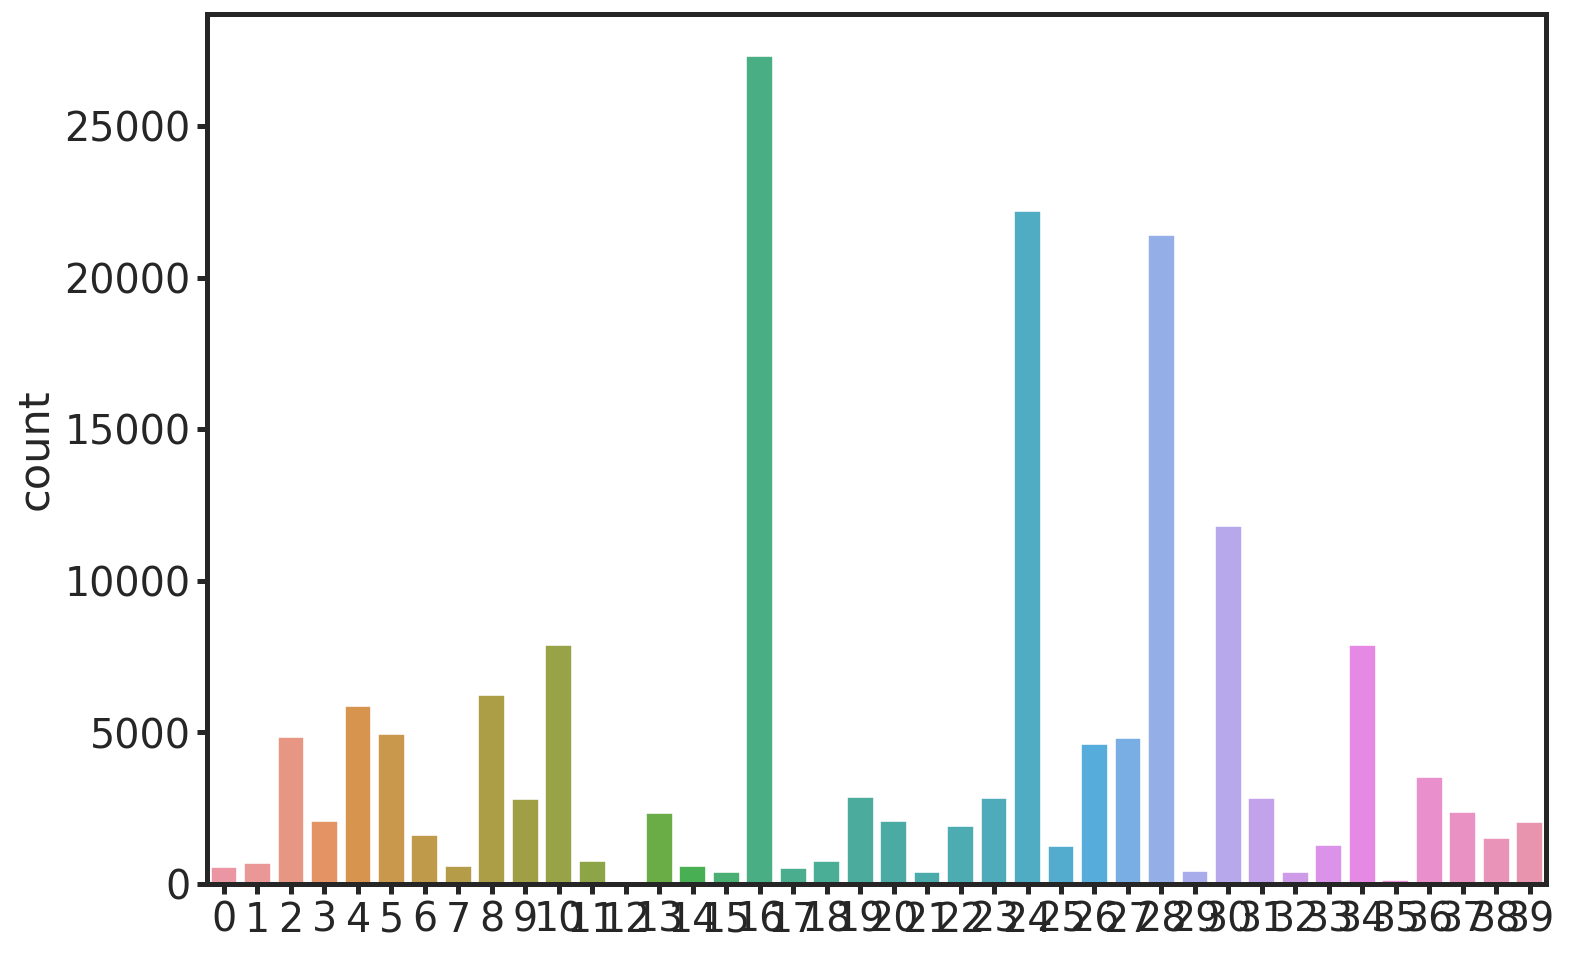

In [29]:
sns.countplot(dataset.labels.ravel())

In [33]:
unique, counts = np.unique(dataset.labels.ravel(), return_counts=True)
dict(zip(unique, counts))

{0: 565,
 1: 687,
 2: 4839,
 3: 2080,
 4: 5862,
 5: 4958,
 6: 1618,
 7: 589,
 8: 6232,
 9: 2820,
 10: 7869,
 11: 750,
 12: 29,
 13: 2358,
 14: 597,
 15: 403,
 16: 27321,
 17: 515,
 18: 749,
 19: 2877,
 20: 2076,
 21: 393,
 22: 1903,
 23: 2834,
 24: 22187,
 25: 1257,
 26: 4605,
 27: 4801,
 28: 21406,
 29: 416,
 30: 11814,
 31: 2828,
 32: 411,
 33: 1271,
 34: 7867,
 35: 127,
 36: 3524,
 37: 2369,
 38: 1507,
 39: 2029}

In [17]:
dataset.graph

{'edge_feat': None,
 'edge_index': array([[104447,  15858, 107156, ...,  45118,  45118,  45118],
        [ 13091,  47283,  69161, ..., 162473, 162537,  72717]]),
 'node_feat': array([[-0.057943, -0.05253 , -0.072603, ...,  0.173364, -0.172796,
         -0.140059],
        [-0.1245  , -0.070665, -0.325202, ...,  0.068524, -0.372111,
         -0.301036],
        [-0.080242, -0.023328, -0.183787, ...,  0.109919,  0.117589,
         -0.139883],
        ...,
        [-0.22053 , -0.036568, -0.402199, ...,  0.11336 , -0.161393,
         -0.145171],
        [-0.138236,  0.040885, -0.251811, ..., -0.08929 , -0.041253,
         -0.376132],
        [-0.029875,  0.268417, -0.161124, ...,  0.120807,  0.077647,
         -0.091018]], dtype=float32),
 'node_year': array([[2013],
        [2015],
        [2014],
        ...,
        [2020],
        [2020],
        [2020]]),
 'num_nodes': 169343}